# Pairs Trading: A python replication of Gatev, Goetzmann and Rouwenhorst (2006)
## Author: Alexandre Rubesam
## Date: May 14, 2023

# Introduction

*This notebook replicates the pairs trading model of [Gatev, Goetzmann and Rouwenhorst (2006)](https://doi.org/10.1093/rfs/hhj020) in python. I used similar pairs trading strategies in my paper [The Long and the Short of Risk Parity](https://www.pm-research.com/content/iijpormgmt/early/2022/01/26/jpm20221333), although the backtesting implementation in that paper is a bit more realistic and was done in Matlab. I had previously written an article with an R implementation, which can be found [here](https://rpubs.com/arubesam/ReplicatingGGR).*



Pairs trading is a type of mean-reversion trading strategy that has been widely used by hedge funds. At its most basic, a pairs trading strategy has two steps. In the first step, the strategy identifies pairs of stocks that historically "move together", according to some criterion. In the second step, a trading rule is used to monitor the behavior of the selected pairs. When a stock in a pair moves away (diverges) from its historical relationship with the other stock, a position is opened, betting that the pair of stocks will go back to its previous pattern. A trade can be closed when the relationship between the two stocks goes back to "normal", or by using other criteria (for example, after a predefined period of time or if a stop loss is triggered). Pairs trading is interesting from both an academic and practical perspectives. If pairs trading is profitable in terms of risk-adjusted returns, it suggests market inefficiency, since the strategy only makes use of historical prices. From a practical perspective, a profitable pairs trading strategy is obviously attractive to investors such as hedge funds, although much more sophisticated types of statistical arbitrage are generally employed in real life.

GGR is probably the most influential paper on pairs trading. Using daily data on U.S. stocks from CRSP, GGR tested a simple pairs trading strategy that selects pairs with minimum squared distance in the space of normalized prices (specifics will be discussed below). The spread (difference) between the prices of two stocks in a pair is used to monitor for trading opportunities. A trade is opened when the spread diverges by more than two historical standard deviations, and is closed when the pair converges (i.e. the spread reverts), or at the end of each trading period

It is well-known that the performance of these simple strategies has declined over time. GGR found robust profits to their pairs trading strategy using a sample from 1962 to 2002. Subsequently, [Do and Faff (2010)](https://doi.org/10.2469/faj.v66.n4.1) extended the sample to 2009, showing a significant decline in the profitability of the strategy in the post-2002 period, although it continued to deliver profits, especially during turbulent periods in the market. They also proposed some refinements that appear to improve the strategy.

In this short article, I replicate the original GGR pairs trading strategy, using CRSP data from January 1962 to December 2020. As will be seen, the profitability of this simple pairs trading strategy in the U.S. has essentially disappeared. Before I proceed with looking at the data, I review a few basic concepts related to the implementation of the strategy.

## Formation and Trading Periods

The GGR pairs trading strategy is implemented using a 12-month period to select pairs, and a 6-month trading period, where the 20 pairs (an arbitrary number) with the smallest squared distances are traded. Because of the 6-month trading period, GGR suggest using 6 overlapping portfolios, each starting one month after the other, similarly to the approach use by [Jegadeesh and Titman (1993)](https://doi.org/10.1111/j.1540-6261.1993.tb04702.x) for momentum. The return of the pairs trading strategy on each period is the average return from the six pairs portfolios.

## Pair Selection

GGR select pairs with minimum "minimum distance between normalized historical prices". In practice, this entails creating a 
synthetic time series of prices for each stock, starting at the value of $\$1$, from the time series of total returns, including dividends. In order to be eligible, a stock needs to have valid return data for the entire formation period, to ensure that the stocks used for pairs formation will be reasonably liquid. Once the universe of eligible stocks for a formation period is defined, we calculate the distances between the normalized prices of all possible pairs of stocks, and 
select the 20 pairs with the minimum distance. This can be computationally intensive: if there are 1,000 eligible stocks, for example, we need to calculate  $(1,000 \times 999)/2 = 499,500$ distances.

It should be noted that this minimum distance criterion is not the only way to select pairs. Other typical approaches use cointegration or copulas to define the pairs. See for example [Rad, Low, and Faff, R. (2016)](https://doi.org/10.1080/14697688.2016.1164337).


## Trading
Once the 20 pairs with the minimum distance are selected, their spreads are monitored during the trading period. A trade is opened if the normalized spread during the trading period exceeds two historical standard deviations, as calculated during the formation period. If the spread is positive, the pair is sold (short position on the first "leg" and long position on the second). If the spread is negative, it's the other way around. GGR test two variations of the strategy, one in which trades are opened on the day the divergence occurs, and another in which trades are opened one day after. The idea of the latter is to reduce the effect of bid-ask bounce. A more reasonable approach in my view is to account for bid-ask spread directly.

A pair is closed if the spread converges (i.e. crosses zero), or if the end of the trading period is reached. This is typically not what is done in practice; other criteria such as a maximum number of days or a stop-loss or stop-gain rule are commonly used.

## Calculation of Returns
As mentioned by GGR, calculating the return of a portfolio of pairs is not a straightforward task, as in principle, the portfolio can have a net position of zero. In addition, multiple positions in any given pair can be opened and closed during the trading period, depending on trading opportunities. A simple and sensible way to obtain reasonable estimates for the daily return on a single pair is to assume that a trade is initiated with $\$1$ long and $\$1$ short positions on the first day of the trade, and update this amount according to the returns on each leg. That is, the return on a pair on day $t$ is given by:

$$
r_{p,t} = w_{1,t} r_1^L - w_{2,t} r_2^S,
$$

where $w_{1,t}$ and $w_{2,t}$ are initially equal to 1, and evolve after that according to the changes in the value of each stock, i.e., $w_{i,t} = w_{i,t-1}(1+r_{i,t-1})$. The returns calculated in this way essentially mimic the evolution of the profit and loss (pnl) of a portfolio with a $\$1$ long and $\$1$ short on each stock.

To calculate the returns on a portfolio of pairs, we need some more assumptions about how capital is allocated to open pairs. GGR suggest two alternatives, the committed capital and the fully invested approaches. Both of these are equally-weighted approaches, in the sense that each pair is always allocated the same amount of money. In the committed capital approach, the full capital of the fund is equally allocated among the 20 pairs, regardless of whether a position is open. In the fully invested approach, the fund's capital at each day is equally allocated among the pairs with open trades. It is important to note that these assumptions are not very realistic: they would require frequent (essentially, daily) rebalancing of the pairs trades. A more realistic approach (which I have followed in my JPM paper linked above) is to simulate a fund with a given starting capital, and open trades on day $t$ using the capital available, keeping the number of shares of the stocks for a pair trade fixed throughout the life of the trade, and accounting for transaction costs in a more direct fashion.

Now that that the strategy is fully explained, let's go to the implementation.

## Data

The data come from CRSP and was obtained from WRDS. I download data for all ordinary U.S. stocks traded in the NYSE, AMEX and NASDAQ (i.e. EXCHCD equal to 1, 2, or 3 and SHRCD equal to 10 or 11). SAS code for this is available upon request. All that is needed to test the strategy are the returns (including dividends), but my database also includes prices and volumes. I include delisting returns following [Johnson and Zhao (2007)](https://doi.org/10.1177/0148558X11409152). The data is in a long format, i.e. each row contains information for one stock for one day.

The data is stored in a csv file. I start by importing standard packages to simplify data manipulation and most calculations, like `numpy` and `pandas`. I also import `matplotlib.pyplot` for graphs. 

The full data set starting in 1962 has about 69 million lines and contains 7 variables: PERMNO, DATE, prc, adjprc, RET, VOL, and EXCHCD. The only variables that we actually need are PERMNO, which uniquely identify each share, DATE, RET (total return including dividends), and VOL (volume in number of shares traded).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# reading the data
path_file = "CRSP_stocks_daily.csv"
data = pd.read_csv(path_file)
data.head()
data.shape
data.dtypes # check all columns have expected data types

,PERMNO,DATE,prc,adjprc,RET,VOL,EXCHCD,RET_DL
0,10000,19860107,2.5625,2.5625,C,1000.0,3.0,NaN
1,10000,19860108,2.5000,2.5000,-0.024390,12800.0,NaN,-0.02439
2,10000,19860109,2.5000,2.5000,0.000000,1400.0,NaN,0.00000
3,10000,19860110,2.5000,2.5000,0.000000,8500.0,3.0,0.00000
4,10000,19860113,2.6250,2.6250,0.050000,5450.0,NaN,0.05000


(78468472, 8)

PERMNO      int64
DATE        int64
prc       float64
adjprc    float64
RET        object
VOL       float64
EXCHCD    float64
RET_DL    float64
dtype: object

In [3]:
# coerce RET to be numeric
data.RET = pd.to_numeric(data.RET, errors = "coerce")

# format date using pandas to_datetime() method
data.DATE = pd.to_datetime(data.DATE, format = "%Y%m%d")

# select only data from 1962 onwards
data = data[data.DATE.dt.year>=1962]


The dataset is in so-called *long format*, that is, each row contains information for one stock on a given date. I would like to work with data in wide or matrix format. I create $T\times N$ matrices for the returns and volumes, i.e., each row represents one day, and each column, a stock. This is easily done using the `pivot()` method. I also keep the unique dates in the dataset and the total number of days.

In [5]:
# data is in long format. Will create wide matrices with volumes and prices
vol = data.pivot(index="DATE", columns="PERMNO", values="VOL")
ret = data.pivot(index="DATE", columns="PERMNO", values="RET")

# remove possible nonsensical returns
ret[ret<-1] = -1
ret.head()

# unique dates
dates = vol.index
total_days = len(dates)
total_days

14853

## Function to Select Pairs

Backtesting a pairs strategy requires repeatedly selecting pairs for each formation period. To make this process more straightforward, I create a function to select the $n$ pairs with the minimum distance, based on a dataframe of total returns. The function outputs a dataframe containing the stocks in each leg of each pair (using the labels in the return matrix), the distance, and the standard deviation of the spread. Selecting the $n$ pairs with minimum distance requires calculations of the distances between all possible pairs of stocks. To have a more efficient calculation, I avoid for loops whenever possible. The function below relies on the `pairwise_distances` function from the `sklearn` package to efficiently calculate all the pairwise distances. Once I have all the distances, I order pairs according to their distances and keep only the top $n$ pairs. For these pairs, I calculate and store the standard deviation of the spread. This function does not need to treat missing values in the returns matrix, as the strategy only selects stocks with complete data over the formation period (i.e. the idea is to screen all the valid stocks first, and provide only the matrix of valid returns to the function).

In [261]:
from sklearn.metrics import pairwise_distances
import itertools

# write a function to select pairs
# function takes as input an array of formation returns and the desired number of pairs
# obs: form_ret column names are inherited original ret object
def get_pairs(form_ret, n_pairs):
    
    # replace first return with 0 so cum returns start at 1
    form_ret.iloc[0, :] = 0
        
    # create object with cumulative returns
    P = (form_ret+1.).cumprod()
    
    # define number of stocks and total number of pairs
    num_stocks = P.shape[1]
    total_pairs = int(P.shape[1]*(P.shape[1]-1)/2)

    # create column with pair combinations to calculate distances
    #pairs = np.asarray(list(itertools.permutations(np.arange(num_stocks),2)))
    pairs = np.asarray(list(itertools.permutations(P.columns,2)))

    # keep only one set of combinations
    pairs = pd.DataFrame(pairs[pairs[:,1] > pairs[:,0]], columns = ["leg_1", "leg_2"])
    
    # calculate distances between normalized prices
    pairs_dist = pairwise_distances(P.transpose(), P.transpose())
    pairs_dist = pd.Series(pairs_dist[np.triu_indices(num_stocks, k=1)])
    pairs["dist"] = pairs_dist

    # remove pairs with 0 distance if any
    pairs = pairs[pairs.dist > 0]

    # order according to distance and select pairs
    pairs = pairs.sort_values("dist", ascending = True)
    pairs = pairs.loc[pairs.index[0:min(n_pairs, pairs.shape[0])]]

    # for these pairs, store the standard deviation of the spread
    pairs["spread_std"] = np.std(np.asarray(P.loc[:, pairs.leg_1]) - np.asarray(P.loc[:, pairs.leg_2]), axis = 0, ddof =1)

    pairs.index = np.arange(pairs.shape[0])
    # returns selected pairs
    return pairs

## Function to Calculate Returns
The previous function will provide the list of pairs to trade for each trading period, along with the historical standard deviation of their spreads in the formation period. Next, I create a function that calculates returns on a portfolio of pairs, using the committed capital or the fully invested approach. The `calculate_pairs_returns` function takes as inputs the returns during the trading period, the list of pairs output by the `get_pairs` function, the number of standard deviations to open a trade, and a parameter that controls whether the strategy should wait one day before opening a trade.

This function needs to identify whether a stock has valid data during the trading period. To do this, I first find the last valid (i.e., non-missing) value for each stock. If one of the stocks in a pair has all returns missing after a certain index, I consider that that stock was delisted, and the trade will be closed on the last available date using the delisting return. Any NAs that occur before are treated as a day with no trading, i.e. I set the return to zero. The logic to open and close trades is based on first identifying all the days when a trade may open (when the absolute value of the spread is higher than `d_open=2` standard deviations) and close (when the spread reverts, i.e. changes sign, or the last day is reached).

The function then calculates the returns and outputs a dictionary containing the pairs, a matrix containing the payoffs (i.e. returns) of each pair for each day, and matrices containing the returns using the two approaches.

In [421]:
# function to calculate returns on a set of pairs over a trading period

def calculate_pairs_returns(trade_ret, pairs, d_open = 2, wait1d = 1):

    # trade_ret : array of returns over trading period
    # pairs  : data frame with information about pairs
    # d_open : number of standard deviations to open a pair
    # wait1d : number of days to wait before opening trade, default = 1
    
    # don't need dates as indices; switch to integers
    trade_ret_dates = trade_ret.index
    trade_ret.index = np.arange(trade_ret.shape[0])
    trade_ret.iloc[0, :] = 0 
    
    # to treat delisting correctly, identify last non NA values
    last_valid_ret_ind = trade_ret.apply(pd.Series.last_valid_index)
    
    # can safely replace NAs with 0 before this index. 
    for idx, column in enumerate(trade_ret.columns):
        r = trade_ret.loc[trade_ret.index[0]:last_valid_ret_ind.iloc[idx], column]
        r = r.fillna(0)
        trade_ret.loc[trade_ret.index[0]:last_valid_ret_ind.iloc[idx], column] = r
        
    # "normalize" trading period prices to start at 1 
    trade_prc = (trade_ret+1.).cumprod()
        
    # total number of days in trading period
    trading_days = trade_prc.shape[0]
        
    # total number of pairs considered
    num_pairs = pairs.shape[0]
    
    # storage for intermediate calculations
    directions = pd.DataFrame(np.zeros((trading_days, num_pairs)))
    payoffs = pd.DataFrame(np.zeros((trading_days, num_pairs)))
    
    # loop through pairs and check for trades
    for idx_pair, pair in pairs.iterrows():
        
        # create df to store weights (the w1 and w2 in GGR) and returns of legs
        pair_calcs = pd.DataFrame(np.zeros((trading_days,9)), columns = ["p_1", "p_2", "s", "direction", "w_1", "w_2", "r_1", "r_2", "payoff"])

        # identify pair legs, build prices, returns and spread vectors
        leg_1 = int(pair.leg_1)
        leg_2 = int(pair.leg_2)
        pair_calcs.p_1 = trade_prc.loc[:, leg_1]
        pair_calcs.p_2 = trade_prc.loc[:, leg_2]
        pair_calcs.r_1 = trade_ret.loc[: , leg_1]
        pair_calcs.r_2 = trade_ret.loc[: , leg_2]
        last_day = max(pair_calcs.p_1.last_valid_index(), pair_calcs.p_2.last_valid_index())
        pair_calcs.r_1 = pair_calcs.r_1.fillna(0)
        pair_calcs.r_2 = pair_calcs.r_2.fillna(0)

        pair_calcs.s = (pair_calcs.p_1 - pair_calcs.p_2) /pair.spread_std

        open_ids = np.array(trade_ret.index*(np.abs(pair_calcs.s) > d_open))
        open_ids = open_ids[open_ids !=0] 
        open_ids = open_ids[open_ids <= last_day]

        close_ids = np.array(trade_ret.index[np.sign(pair_calcs.s).diff() != 0])
        close_ids = close_ids[~np.isnan(close_ids)]
        close_ids = np.append(close_ids, last_day)

        # date when first trade opens
        if len(open_ids) !=0:
            t_open = open_ids[0]
        else:
            t_open = np.nan

        # if there has been a divergence in the trading period
        if (~np.isnan(t_open)):
            while (~np.isnan(t_open) & (t_open < last_day - wait1d) ):
                # check when trade closed
                t_close = np.min(close_ids[close_ids > t_open + wait1d])

                # store direction of trade over period when trade is open
                pair_calcs.loc[(t_open + wait1d +1): (t_close+1), "direction"] = -np.sign(pair_calcs.loc[t_open - wait1d, "s"])

                # update w1 and w2
                pair_calcs.w_1[(t_open + wait1d):(t_close+1)] = np.append(1., (1 + pair_calcs.r_1[(t_open + wait1d) : (t_close)]).cumprod())
                pair_calcs.w_2[(t_open + wait1d):(t_close+1)] = np.append(1., (1 + pair_calcs.r_2[(t_open + wait1d) : (t_close)]).cumprod())
                
                # update t_open => moves to next trade for this pair
                if any(open_ids > t_close):
                    t_open = open_ids[open_ids > t_close][0]
                else:
                    t_open = np.nan
                    
        # calculate and store the payoffs for this pair
        pair_calcs["payoffs"] = pair_calcs.direction*(pair_calcs.w_1 * pair_calcs.r_1 - pair_calcs.w_2 * pair_calcs.r_2)
        payoffs.loc[:, idx_pair] = pair_calcs["payoffs"]
        directions.loc[:, idx_pair] = pair_calcs["direction"]
        
    directions.index = trade_ret_dates
    payoffs.index = trade_ret_dates
        
    # returns for committed capital approach - just the column average of payoffs
    returns_cc = payoffs.mean(axis=1)

    # for fully-invested approach, capital is divided among open pairs

    num_open_pairs = (directions != 0).sum(axis=1)
    num_open_pairs[num_open_pairs>0] = 1./num_open_pairs
    weights_fi = pd.concat([num_open_pairs]*num_pairs, axis = 1)
    returns_fi = (weights_fi * payoffs).sum(axis=1)
     
    # return everything as a dictionary
    return {"pairs": pairs, "directions": directions,  "payoffs": payoffs, "returns_cc": returns_cc, "returns_fi": returns_fi}    

## Preliminary Analysis

Before going though the main loop that backtests the strategy over the entire period, I show below the logic and some details for the first formation and trading periods of the first overlapping portfolio. Since the sample starts in January 1962, this formation period goes from the beginning of January 1962 to the last day of December 1962, whereas the trading period goes from the first available day of January 1963 to the last day of June 1963. Since the `ret` and `vol` objects are indexed by `datetime`, it's straightforward to select specific sample periods. The chunk of code below creates copies of the slices of data corresponding to the first formation and trading period, applies the `get_pairs` function and displays the resulting pairs. 

In [600]:
# test the function for a specific date
n_pairs = 20

# formation period total return including dividends
form_ret = ret.loc["1962-01-01":"1962-12-31"].copy()

# daily volumes for formation period
form_vol = vol["1962-01-01":"1962-12-31"].copy()
form_vol[form_vol.isna()] = 0

# boolean to identify eligible stocks
ava_stocks = (form_ret.isna().sum() == 0) & ((form_vol == 0).sum() == 0)

# create matrices with formation and trading prices only for selected stocks
form_ret = ret.loc["1962-01-01":"1962-12-31",  ava_stocks]
trade_ret = ret.loc["1963-01-01":"1963-06-30", ava_stocks]

pairs = get_pairs(form_ret, n_pairs = 20)
pairs

,leg_1,leg_2,dist,spread_std
0,16870,20853,0.334883,0.017692
1,23026,25590,0.359840,0.022234
2,11404,16870,0.373151,0.023538
3,10137,25072,0.386046,0.024293
4,11404,23229,0.386278,0.023177
5,11754,17849,0.388226,0.022940
6,11340,21776,0.390174,0.024417
7,15499,25726,0.391369,0.023661
8,14509,14795,0.391597,0.024575
9,22541,24109,0.392941,0.024545


To get a better understanding of the mechanics of the pairs trading model, let's investigate the normalized prices of the first pair. The code below selects the first pair, calculates normalized prices and standardized spreads and plots these over the formation (left side) and trading (right side) periods. Note that the normalized spread in the trading period is calculated using the standard deviation spread in the formation period, i.e., it is fully *out of sample*.

The top left graph shows clearly that these two stocks were moving closely together in the formation period. If we knew the standard deviation of the spread on this pair at the beginning of the formation period, we could open trades when the spread diverged by more than two standard deviations, shown in the bottom left graph below as solid red and blue lines. In this case, there were only opportunities to sell the pair. 

Note, however, the standard deviation of the spread is not known at the beginning of the formation period. The graphs on the right show the corresponding estimates during the subsequent, *out-of-sample*, trading period. This example shows one of the main risks of pairs trading, which is when trades don't converge. Even though the two stocks appeared to have a very close relationship during the formation period, they subsequently showed different behavior during the trading period. We would have opened a long position on the pair at the end of January 1963, and would close it at a loss at the end of the trading period.

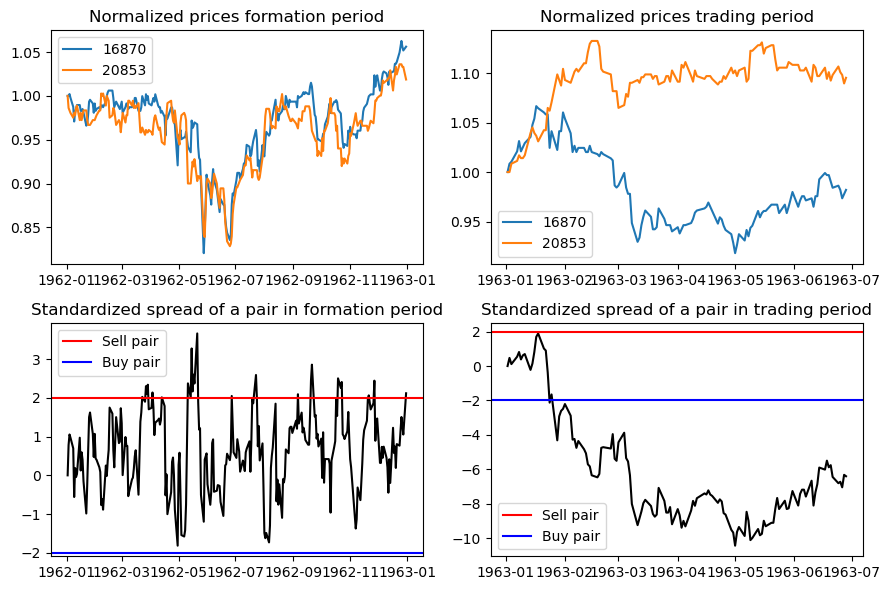

In [601]:
# use first pair in this example
i_pair = 0

rets_pair_form = form_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_form.iloc[0,:] = 0

# normalized prices and std spread in formation period
norm_prices_form = (1+rets_pair_form).cumprod()
norm_prices_form["std_spread"] = (norm_prices_form[pairs.leg_1[i_pair]] - norm_prices_form[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]

# normalized prices and std spread in trading period
rets_pair_trade = trade_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_trade.iloc[0,:] = 0
norm_prices_trade = (1+rets_pair_trade).cumprod()
norm_prices_trade["std_spread"] = (norm_prices_trade[pairs.leg_1[i_pair]] - norm_prices_trade[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]


# ploting: left = formation period, right = trading period

# plot normalized prices and std spread in trading period
fig = plt.figure();
fig.set_size_inches(9, 6);
ax1 = fig.add_subplot(2,2,1);
ax1.plot(norm_prices_form[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax1.legend();
ax1.set_title("Normalized prices formation period");

ax2 = fig.add_subplot(2,2,3);
ax2.plot(norm_prices_form["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax2.legend();
ax2.set_title("Standardized spread of a pair in formation period");
fig.tight_layout();

ax3 = fig.add_subplot(2,2,2);
ax3.plot(norm_prices_trade[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax3.legend();
ax3.set_title("Normalized prices trading period");

ax3 = fig.add_subplot(2,2,4);
ax3.plot(norm_prices_trade["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax3.legend();
ax3.set_title("Standardized spread of a pair in trading period");
fig.tight_layout();





Of course, this is not always the case. For the pair shown below, we would have sold the pair at a profit at least twice:

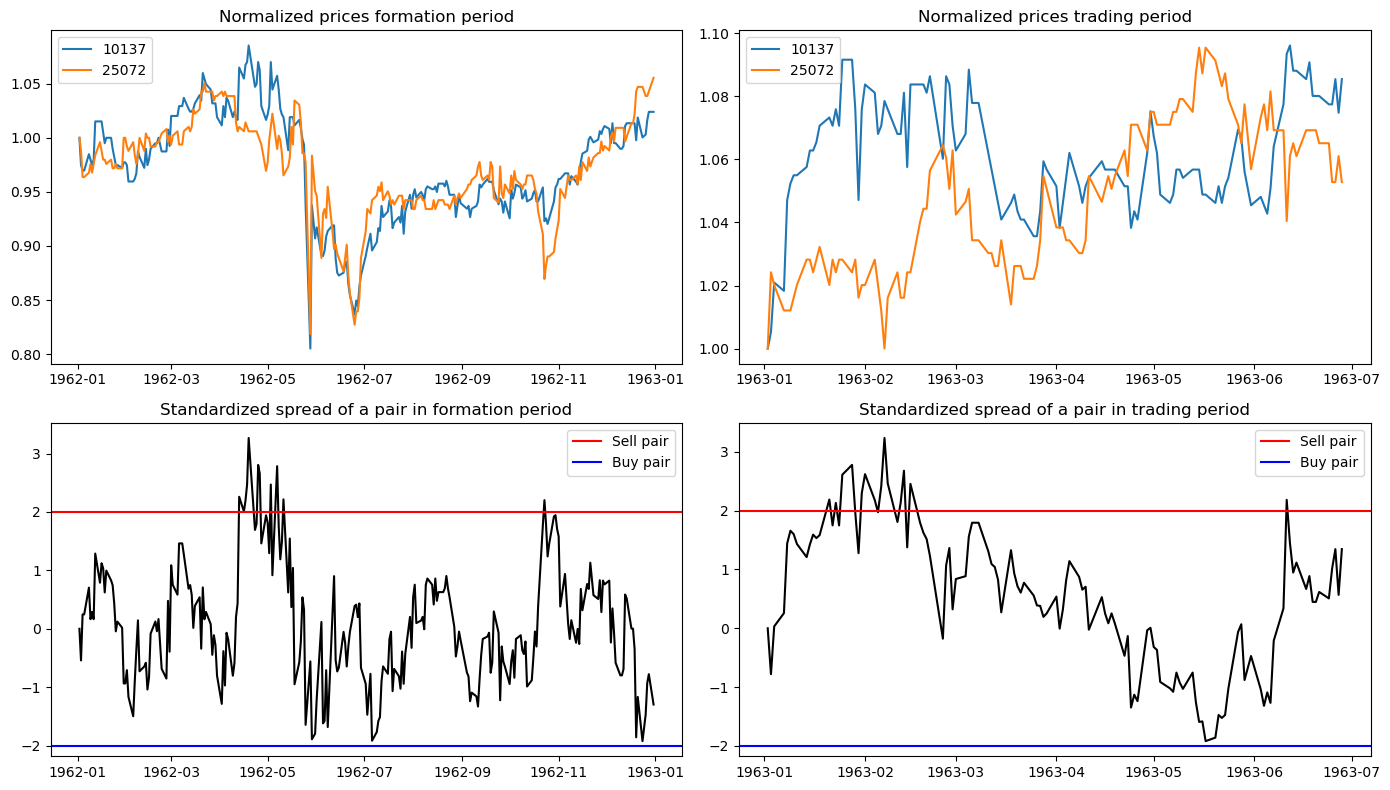

In [602]:
# inspecting another pair
i_pair = 3

rets_pair_form = form_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_form.iloc[0,:] = 0

# normalized prices and std spread in formation period
norm_prices_form = (1+rets_pair_form).cumprod()
norm_prices_form["std_spread"] = (norm_prices_form[pairs.leg_1[i_pair]] - norm_prices_form[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]

# normalized prices and std spread in trading period
rets_pair_trade = trade_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_trade.iloc[0,:] = 0
norm_prices_trade = (1+rets_pair_trade).cumprod()
norm_prices_trade["std_spread"] = (norm_prices_trade[pairs.leg_1[i_pair]] - norm_prices_trade[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]


# ploting: left = formation period, right = trading period

# plot normalized prices and std spread in trading period
fig = plt.figure();
fig.set_size_inches(9, 6);
ax1 = fig.add_subplot(2,2,1);
ax1.plot(norm_prices_form[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax1.legend();
ax1.set_title("Normalized prices formation period");

ax2 = fig.add_subplot(2,2,3);
ax2.plot(norm_prices_form["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax2.legend();
ax2.set_title("Standardized spread of a pair in formation period");
fig.tight_layout();

ax3 = fig.add_subplot(2,2,2);
ax3.plot(norm_prices_trade[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax3.legend();
ax3.set_title("Normalized prices trading period");

ax3 = fig.add_subplot(2,2,4);
ax3.plot(norm_prices_trade["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax3.legend();
ax3.set_title("Standardized spread of a pair in trading period");
fig.tight_layout();

Let's calculate the excess returns for the 20 pairs in this first trading period. I apply the `calculate_pairs_returns` function with the chosen pairs and plot the cumulative returns for each pair, as well as the portfolio return using the committed capital approach. Even though many pairs lost money, overall the strategy was profitable, earning a little over 3%.

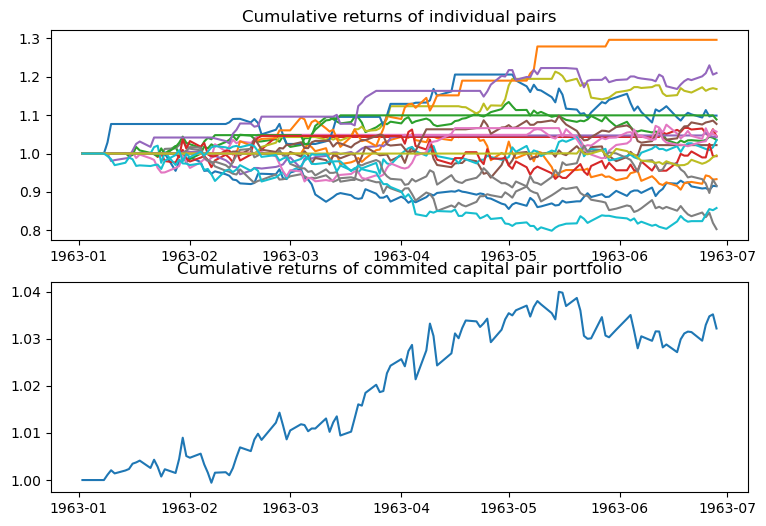

In [603]:
trades = calculate_pairs_returns(trade_ret.copy(), pairs = pairs, d_open = 2, wait1d = 1)
# returns of all pair trades 
pair_rets = trades["payoffs"]

fig = plt.figure();
fig.set_size_inches(9, 6);
ax1 = fig.add_subplot(2,1,1);
ax1.plot((1+pair_rets).cumprod());
ax1.set_title("Cumulative returns of individual pairs");
ax2 = fig.add_subplot(2,1,2);
ax2.plot((1+trades["returns_cc"]).cumprod());
ax2.set_title("Cumulative returns of commited capital pair portfolio");


## Backtesting the Strategy
Now that the dynamics of the GGR pairs trading strategy is a bit clearer, let's move on to the backtest of the strategy over the entire period. To make it convenient to identify the formation and trading periods, I create a variable that identifies the sequential number of the month of each day in the sample. The code below sets up the parameters of the strategy, creates objects to store the outputs, and creates an object identifying the month of each day. The variable `wait1d` is used to decide whether to wait one day to open a trade. This was used in the GGR paper as an indirect way to account for transaction costs. 

In [607]:
# initialization to backtest strategy
n_formation = 12
n_trading = 6
num_pairs = 20
d_open = 2
wait1d = 1

# storage for results
strat_returns_cc_w1d = pd.DataFrame(np.zeros((total_days, n_trading)), index = dates, columns = ["P_"+str(i+1) for i in range(n_trading)])
strat_returns_fi_w1d = strat_returns_cc_w1d.copy()
num_open_pairs_w1d = pd.DataFrame(np.zeros((total_days, n_trading)), index = dates, columns = ["P_"+str(i+1) for i in range(n_trading)])

# create indices of months in sample
month_id = pd.Series(dates.month)
month_id = (month_id.diff()!=0)
month_id[0] = 0
month_id = month_id.cumsum()

unique_months = month_id.unique()

Below is the main loop to calculate the returns on the six overlapping portfolios over the entire sample period. The logic for the selection of formation and trading periods is based on the `month_id` variable. This code hasn't been optimized, but it's clear that it could potentially be parallelized, as each overlapping portfolio is independent. In addition, trades in each trading period are also independent of previous formation and trading periods. Backtesting each portfolio over the entire 58-year period, with daily data, took less than 9 minutes on an AMD Ryzen 7 3700X, which is not bad.

In [434]:
# Main backtesting loop

import time

for i_port in range(n_trading):

    port_name = "P_" + str(i_port+1)

    print("Running portfolio " + str(i_port+1) + " of ", str(n_trading))
    tic = time.perf_counter()

    # Each portfolio pairs can start after (n_formation + i - 1) months 
    # eg. portfolio 1 can start after 12 months if n_formation = 12
    #     portfolio 2 can start after 13 months etc


    for i in np.arange(start = n_formation+i_port, stop = len(unique_months)-n_trading+1, step = n_trading):
        
        #tic = time.perf_counter()
        train = np.array(unique_months[i-n_formation:i])
        test = np.array(unique_months[i:i+n_trading])
        form_dates = pd.date_range(dates[month_id == train.min()][0], dates[month_id == train.max()][-1])
        trade_dates = pd.date_range(dates[month_id == test.min()][0], dates[month_id == test.max()][-1])    

        #print("Formation: ", form_dates[0], " to ", form_dates[-1])
        #print("Trading: ", trade_dates[0], " to ", trade_dates[-1])

        # check available stocks

        # select only stocks:
        #  - with returns for entire formation period
        #  - with volumes > 0 for every day of formation period

        form_ret = ret[form_dates[0]:form_dates[-1]].copy()

        # daily volumes for formation period
        form_vol = vol[form_dates[0]:form_dates[-1]].copy()
        form_vol = form_vol.fillna(0)

        #toc = time.perf_counter()
        #print(f"Slicing data took {(toc - tic):0.4f} seconds")
    
        #tic = time.perf_counter()
        # boolean to identify eligible stocks
        ava_stocks = (form_ret.isna().sum() == 0) & ((form_vol == 0).sum() == 0)

        # formation and trading returns for selected stocks
        form_ret = ret.loc[form_dates[0]:form_dates[-1], ava_stocks]
        trade_ret = ret.loc[trade_dates[0]:trade_dates[-1], ava_stocks]

        # select pairs
        pairs = get_pairs(form_ret, 20)
        
        #toc = time.perf_counter()
        #print(f"Selecting pairs took {(toc - tic):0.4f} seconds")

        #tic = time.perf_counter()
        # trade pairs
        trades = calculate_pairs_returns(trade_ret, pairs, d_open, wait1d)    
        #toc = time.perf_counter()
        #print(f"Calculating pairs returns took {(toc - tic):0.4f} seconds")
        
        # store results
        strat_returns_cc_w1d.loc[trade_dates[0]:trade_dates[-1], port_name] = trades["returns_cc"].values
        strat_returns_fi_w1d.loc[trade_dates[0]:trade_dates[-1], port_name] = trades["returns_fi"].values
        num_open_pairs_w1d.loc[trade_dates[0]:trade_dates[-1], port_name] = (trades["directions"]!=0).sum(axis=1).values

    toc = time.perf_counter()
    print(f"Running portfolio took {(toc - tic)/60.:0.2f} minutes")



Running portfolio 1 of  6
Running portfolio took 8.86 minutes
Running portfolio 2 of  6
Running portfolio took 8.44 minutes
Running portfolio 3 of  6
Running portfolio took 8.50 minutes
Running portfolio 4 of  6
Running portfolio took 8.52 minutes
Running portfolio 5 of  6
Running portfolio took 8.56 minutes
Running portfolio 6 of  6
Running portfolio took 8.58 minutes


After the daily excess returns for the overlapping portfolios are calculated, I calculate the returns on the committed capital and fully invested portfolios of pairs, and then compound them to obtain monthly returns for a comparison with GGR. The bar plot below shows the monthly excess returns on the committed capital pairs portfolio. Although the overall pattern is very similar to that reported by GGR, the range of returns is a bit different, especially the extreme positive returns they report in the early 1970s. My plot, however, is almost identical to the graph reported by Do and Faff (2010). Although the strategy still delivered some decent returns during the Great Financial Crisis (GFC), we can clearly see the degradation in the returns of the GGR strategy after that.

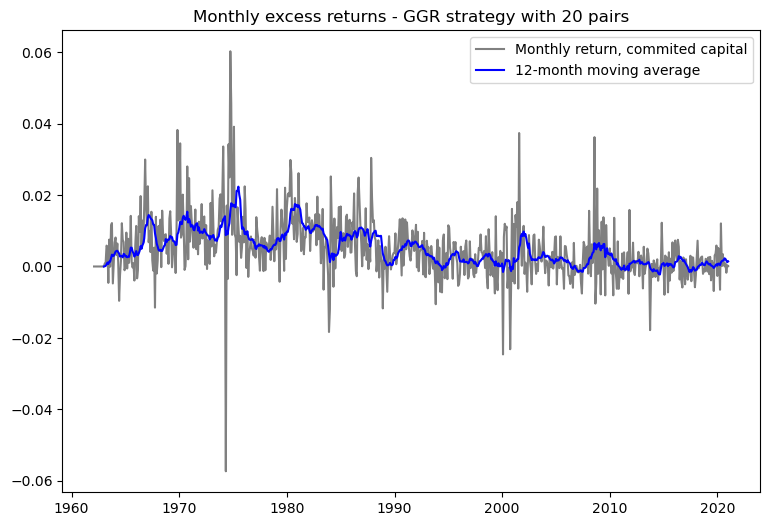

In [598]:
# returns on portfolio are the averages of six overlapping portfolios
ret_cc_w1d = strat_returns_cc_w1d.mean(axis = 1)
ret_fi_w1d = strat_returns_fi_w1d.mean(axis = 1)

# dataframe with daily returns of commited capital (cc) and fully invested (fi)
ret_daily = pd.DataFrame({"ret_cc": ret_cc_w1d, "ret_fi": ret_fi_w1d})

# calculate monthly returns - used resample at monthly frequency and lambda function to compound
ret_monthly = ret_daily.resample('M').agg(lambda x: (x + 1).prod() - 1)

# calculate 12-month moving average
ret_12_month = ret_monthly.rolling(12).mean()
ret_12_month

fig = plt.figure();
fig.set_size_inches(9, 6);
ax = fig.add_subplot();
ax.plot(ret_monthly["ret_cc"], color = "gray", label = "Monthly return, commited capital" );
ax.plot(ret_12_month["ret_cc"], color = "blue", label = "12-month moving average");
ax.set_title("Monthly excess returns - GGR strategy with 20 pairs")
ax.legend();

Next, I plot the log of the cumulative returns over the entire sample period. The shapes are very similar to what GGR report. Again, the degradation in the post-GFC period is very clear, with almost flat returns after 2010.

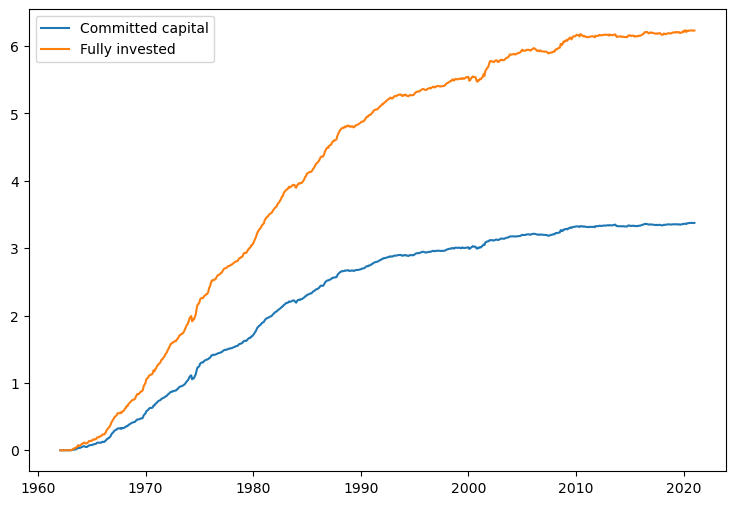

In [597]:
fig = plt.figure();
fig.set_size_inches(9, 6);
ax = fig.add_subplot();
ax.plot(np.log((1+ret_monthly).cumprod()));
ax.legend(('Committed capital','Fully invested'));

Zooming in to the post-GGR period allows us to see the decline in the profitability of the strategy after the 2008 crisis:

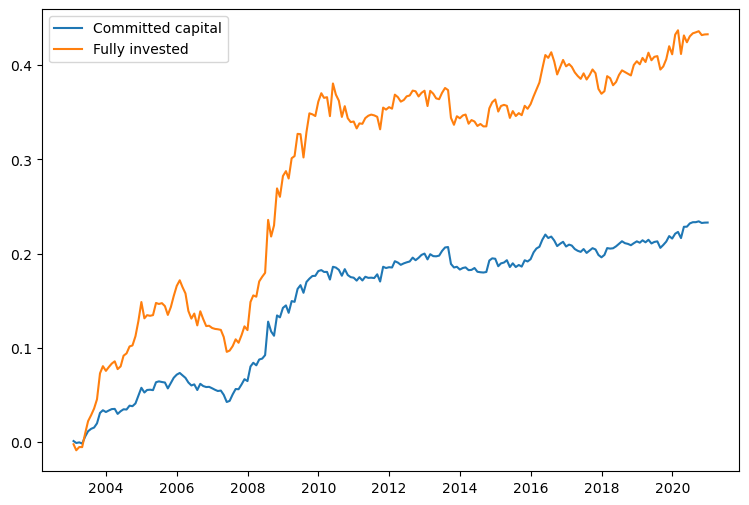

In [596]:
fig = plt.figure();
fig.set_size_inches(9, 6);
ax = fig.add_subplot();
ax.plot(np.log((1+ret_monthly[ret_monthly.index.year>=2003]).cumprod()));
ax.legend(('Committed capital','Fully invested'));

Now to calculate some performance statistics. I consider three periods: the original GGR sample period (July 1963 to December 2002), the "post-GGR" sample in Do and Faff (2010), from January 2003 to June 2009, and the remaining post-GFC period, from July 2009 to December 2020. I define a function to calculate maximum drawdown, and use the `groupby()` and `agg()` methods from pandas to calculate the statistics for the different periods. 

In [604]:
# calculating statistics of monthly returns for various sample period

from scipy.stats import kurtosis
from scipy.stats import skew

# function to calculate max drawdown from returns
def max_dd(x):
    p = (1+x).cumprod()
    roll_max = p.cummax()
    drawdown = p/roll_max - 1.0
    max_drawdown = drawdown.cummin()
    return -max_drawdown[-1]


# create variables to identify various sample periods
full_sample = pd.Series(np.repeat(True, ret_monthly.shape[0]), index = ret_monthly.index)
GGR_sample = pd.Series((ret_monthly.index >= "1963-07") & (ret_monthly.index <= "2002-07"), index = ret_monthly.index)
Do_Faff_sample =  pd.Series((ret_monthly.index >= "2003-01") & (ret_monthly.index <= "2009-07"), index = ret_monthly.index)
post_GFC_sample = pd.Series((ret_monthly.index >= "2009-07"), index = ret_monthly.index)

# add to dataframe
ret_monthly = ret_monthly.assign(full_sample = full_sample, GGR_sample = GGR_sample, Do_Faff_sample = Do_Faff_sample, post_GFC_sample = post_GFC_sample)
# calculate statistics of monthly returns for different periods
stats_full = ret_monthly.groupby(full_sample)[["ret_cc", "ret_fi"]].agg(["mean", "std", "median", "min", "max", skew, kurtosis, max_dd])
stats_full.index = ["Full sample"]
stats_full = stats_full.transpose()

stats_GGR = ret_monthly[ret_monthly.GGR_sample == True].groupby(GGR_sample)[["ret_cc", "ret_fi"]].agg(["mean", "std", "median", "min", "max", skew, kurtosis, max_dd])
stats_GGR.index = ["GGR sample"]
stats_GGR = stats_GGR.transpose()
    
stats_Do_Faff = ret_monthly[ret_monthly.Do_Faff_sample == True].groupby(Do_Faff_sample)[["ret_cc", "ret_fi"]].agg(["mean", "std", "median", "min", "max", skew, kurtosis, max_dd])
stats_Do_Faff.index = ["Do Faff sample"]
stats_Do_Faff = stats_Do_Faff.transpose()

stats_post_GFC = ret_monthly[ret_monthly.post_GFC_sample == True].groupby(post_GFC_sample)[["ret_cc", "ret_fi"]].agg(["mean", "std", "median", "min", "max", skew, kurtosis, max_dd])
stats_post_GFC.index = ["Post-GFC sample"]
stats_post_GFC = stats_post_GFC.transpose()

# consolidate into a single table
stats_table = pd.concat([stats_full, stats_GGR, stats_Do_Faff, stats_post_GFC], axis = 1)
stats_table

Full sample  GGR sample  Do Faff sample  Post-GFC sample
ret_cc mean         0.004814    0.006708        0.002158         0.000492
       std          0.008578    0.009300        0.006706         0.004515
       median       0.003710    0.005885        0.001053         0.000588
       min         -0.057301   -0.057301       -0.010392        -0.017808
       max          0.060216    0.060216        0.036189         0.015825
       skew         0.648129    0.235690        2.025701         0.073599
       kurtosis     7.943622    7.992350        7.670560         2.476196
       max_dd       0.057301    0.057301        0.030333         0.026690
ret_fi mean         0.008949    0.012474        0.004274         0.000816
       std          0.014961    0.015631        0.012527         0.009748
       median       0.007320    0.011272        0.003149         0.000746
       min         -0.076688   -0.076688       -0.018440        -0.029049
       max          0.087810    0.087810        0.057818         0.035294
       skew         0.461056    0.146884        1.294313         0.138316
       kurtosis     4.195648    4.912712        3.598253         1.511177
       max_dd       0.076688    0.076688        0.073188         0.047521

For the GGR period and when trades are opened one day after the day of divergence, I obtain average monthly excess returns of 0.67% and 1.25% for the committed capital and fully invested strategies, respectivelly. This compares to 0.52% and 0.90% reported by GGR. Therefore, the numbers are close, but not identical, which is also the case for the other statistics. Since GGR don’t explain in much detail some aspects of their calculation of pair excess returns, it’s difficult to know the source of the difference.

For the post-GGR period (2003-2009), the pairs trading strategy shows a significant reduction in profitability, as reported by Do and Faff (2010). However, the numbers I obtain are higher than those reported by Do and Faff (2010) for this period. Incidentally, Do and Faff (2010) report nearly identical numbers for the committed capital and fully invested approaches, which seems odd, given that the fully invested strategy should have higher leverage than the committed capital one. In any case, when trades are opened one day after divergence, the average monthly returns of the committed capital and fully invested approaches decrease to 0.22% and 0.43%. This is particularly odd, as I get very similar results for the other periods reported by Do and Faff.

Finally, for the post-GFC period, returns decrease dramatically, and range between 0.05% and 0.08% per month, depending on the strategy. That is, we can say with some confidence that the simple distance-based pairs trading strategy doesn’t work after the GFC. This is the same conclusion reached in my JPM paper, in which I backtested the GGR as well as a cointegration-based pairs trading strategy using a more realistic approach, by simulating the evolution of a fund that starts with an initial capital and invests in pairs trading strategies, incurring transaction costs along the way according to the trades executed, taking into account transaction costs. In that paper, I estimate the daily turnover of the GGR pairs trading strategy to be around 5%, which leads to a decrease of approximately 30 bps (0.30%) per month in returns. 

## Concluding Remarks
In this post, I replicate some results from the simple distance-based pairs trading strategy of Gatev, Goetzmann and Rouwenhorst (2006) and Do and Faff (2010), extending the sample to the end of 2020. I show that the profitability of the strategy has decreased to essentially zero after 2009. Therefore, we can safely assume that this simple pairs trading strategy is no longer profitable after this period. I hope this code will be useful to researchers exploring this type of strategy.

In [612]:
print("Reading data file...", end ="")
tic = time.perf_counter()
time.sleep(1)
print("done")
toc = time.perf_counter()
print(f"Reading data file took {(toc - tic):0.2f} seconds")

Reading data file...done
Reading data file took 1.01 seconds
